## Mother Daughter Δψ asymmetry analysis

In [4]:
%matplotlib inline

In [5]:
import os
import os.path as op
import cPickle as pickle
import fnmatch
from collections import defaultdict
import pandas as pd
import seaborn as sns
from mombud.vtk_viz import vtk_mbfuncs as vf
import matplotlib.pyplot as plt
import numpy as np

Set defaults for plotting

In [6]:
plt.rcParams['font.family'] = 'DejaVu Sans'
vtkF = defaultdict(dict)
sns.set_style('whitegrid')

Dataframe and bins initialization

In [7]:
datadir = op.join(os.getcwd(),'data')
vtkF = defaultdict(dict)
cellall = pd.DataFrame(columns=['mom', 'bud'])
cellposmom = pd.DataFrame()
cellposbud = pd.DataFrame()
neckregion = pd.DataFrame()
binsbudprog = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5,
                        0.6, 0.7, 0.8, 0.9, 1., 2.])
binsaxis = np.linspace(0., 1., 6)
binsaxisbig = np.linspace(0, 1., 11)
binsvolbud = np.linspace(0, 40, 5)
binsvolmom = np.array([0, 30, 40, 80.])

Load data files which are coordinates and Δψ values along the mitochondrial network

In [8]:
with open(op.join(datadir, 'transformedData', 'mombudtrans.pkl'), 'rb') as inpt:
    dfmb = pickle.load(inpt)  # has columns base, neck, tip, media, bud, mom

for root, dirs, files in os.walk(op.join(datadir,'transformedData')):
    for i in files:
        if fnmatch.fnmatch(i, '*.vtk'):
            media = root.rsplit(os.sep, 1)[1]
            vtkF[media][i[:-4]] = op.join(root, i)

filekeys = {item: vtkF[media][item] for media
            in sorted(vtkF.keys()) for item
            in sorted(vtkF[media].keys())}

Partition the mom and daughter cells using the points picked in the 'mombudtrans.pkl'. 

In [9]:

for _, key in enumerate(sorted(filekeys.keys())[:]):
    cell = vf.cellpos(filekeys[key], dfmb)
    # pos along x-axis for inidivual mom or bud cell
    cell['binposx'] = vf.bincell(cell, 'posx', binsaxis)
    # scaled Δψ to min-max of the GRADIENT within mom/bud
    Xmom = cell.ix[cell['type'] == 'mom'].groupby('binposx').DY.mean()
    Xbud = cell.ix[cell['type'] == 'bud'].groupby('binposx').DY.mean()
    # pos along x-axis for the whole cell
    cell['binposxcell'] = vf.bincell(cell, 'posxcell', binsaxisbig)
    # scale Δψ to min-max of the GRADIENT within cell
    DYcell = cell.groupby('binposxcell').DY.mean()
    Xmom = vf.scaleminmax(Xmom, DYcell)
    Xbud = vf.scaleminmax(Xbud, DYcell)
    Xbud.name = key
    Xmom.name = key
    medianDY = cell.groupby('type').median().DY
    medianDY.name = key
    cellall = cellall.append(medianDY)
    cellposbud = cellposbud.append(Xbud)
    cellposmom = cellposmom.append(Xmom)
    # temp dict of mean Δψ at +- range of dist from budneck
    tempdic = {dist: vf.neckDY(cell, cell.neckpos, dist)
               for dist in [.15, .3, .5]}
    temp = pd.DataFrame({'bud': pd.Series({k: tempdic[k][0] for k in tempdic}),
                         'mom': pd.Series({k: tempdic[k][1] for k in tempdic}),
                         'cellname': key})
    temp['dist'] = temp.index
    temp.set_index('cellname', inplace=True)
    neckregion = neckregion.append(temp, ignore_index=False)

cellall['budvol'] = dfmb.bud
cellall['momvol'] = dfmb.mom
cellall = cellall.reset_index()
cellall['type'] = cellall['index'].apply(lambda x: x[:3])
cellposbud = cellposbud.reset_index()
cellposmom = cellposmom.reset_index()
cellposbud = pd.concat([cellposbud, cellall.ix[:, ['type', 'neck']]], axis=1)
cellposmom = pd.concat([cellposmom, cellall.ix[:, ['type', 'neck']]], axis=1)

cellall['frac'] = cellall.ix[:, 'bud'] / cellall.ix[:, 'mom']
Q = cellall.groupby('type').quantile(.90)  # 90th percentile of each cols
#  q90 = 90th percentile bud volume of each media type
cellall['q90'] = cellall.type.apply(lambda x: Q.ix[x].budvol)
gt90 = cellall[cellall['budvol'] > cellall['q90']]
meangt90 = gt90.groupby('type').budvol.mean()
cellall['mean90'] = cellall.type.apply(lambda x: meangt90.ix[x])
#  budvolratio is based on the largest 10% cells
cellall['budvolratio'] = cellall.budvol / cellall.q90
cellposbud['budvol'] = cellall['budvol']
cellposmom['momvol'] = cellall['momvol']

cellposbud['binvol'] = vf.bincell(cellposbud, 'budvol', binsvolbud)
cellposmom['binvol'] = vf.bincell(cellposmom, 'momvol', binsvolmom)

Cells binned by their progression along the cell cycle

In [10]:
BIG = pd.melt(cellall,
              id_vars=['type'],
              value_vars=['frac'])
groups = BIG.groupby('type')

BIG2 = pd.melt(cellall,
               id_vars=['type'],
               value_vars=['mom', 'bud'])

cellall['bin_budprog'] = vf.bincell(cellall, 'budvolratio', binsbudprog)


cellall['binbudvol'] = cellposbud['binvol']

# reject super large cells
rejectlist = cellposmom.ix[(np.asarray(cellposmom.momvol) > 60) &
                           (cellposmom.type != 'YPD'), 'index']
cellall = cellall.ix[~ cellall.ix[:, 'index'].isin(rejectlist)]
cellposmom = cellposmom.ix[~cellposmom.ix[:, 'index'].isin(rejectlist)]
cellposbud = cellposbud.ix[~cellposbud.ix[:, 'index'].isin(rejectlist)]

Finally, convert the DataFrames into 'long-form'.

In [11]:
bigbinsmom = pd.melt(cellposmom,
                     id_vars=['type', 'binvol'],
                     var_name='mom axis position',
                     value_name=r'$\Delta\Psi$ scaled gradient',
                     value_vars=binsaxis.tolist())
bigbinsmom = bigbinsmom.dropna()
bigbinsbud = pd.melt(cellposbud,
                     id_vars=['type', 'binvol'],
                     var_name='bud axis position',
                     value_name=r'$\Delta\Psi$ scaled gradient',
                     value_vars=binsaxis.tolist())
bigbinsbud = bigbinsbud.dropna()

It is well known that buds are functionally 'younger' than their mothers. This is shown for example when we compare their average mitochondrial membrane potential (Δψ) of the bud population vs mother populations.

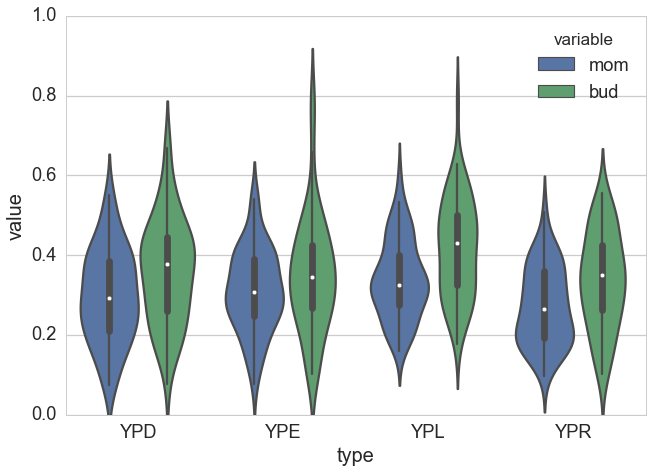

In [12]:
with sns.plotting_context('talk', font_scale=1.4):
    _, ax3 = plt.subplots(1, 1)
    h = sns.violinplot(x='type',
                       y='value',
                       hue='variable',
                       data=BIG2,
                       ax=ax3)
    h.set_ylim(0, 1.)


What is not so well known is how the distribution of (Δψ) varies along the mother cell axis in three dimensions. Shown below is a plot of the distribution along the mother cell populations.

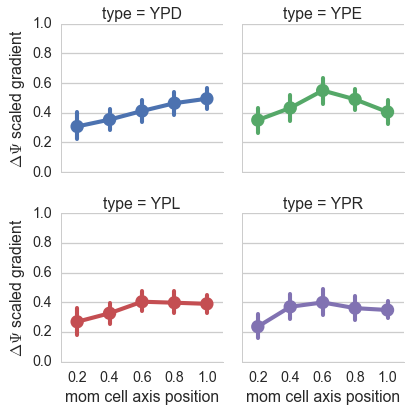

In [13]:
with sns.plotting_context('talk', font_scale=1.1):
    h = sns.FacetGrid(bigbinsmom,
                      col="type",
                      hue='type',
                      col_wrap=2)
    h = h.map(sns.pointplot,
              'mom axis position',
              r'$\Delta\Psi$ scaled gradient')
    h.set_xlabels('mom cell axis position')
    h.set(ylim=(0, 1.))

Plot of mitochondrial membrane potential (Δψ) profile along the bud cell axis. Buds are partitioned according to their cell volume, with smaller buds indicating a bud at an earlier point along the cell growth cycle.

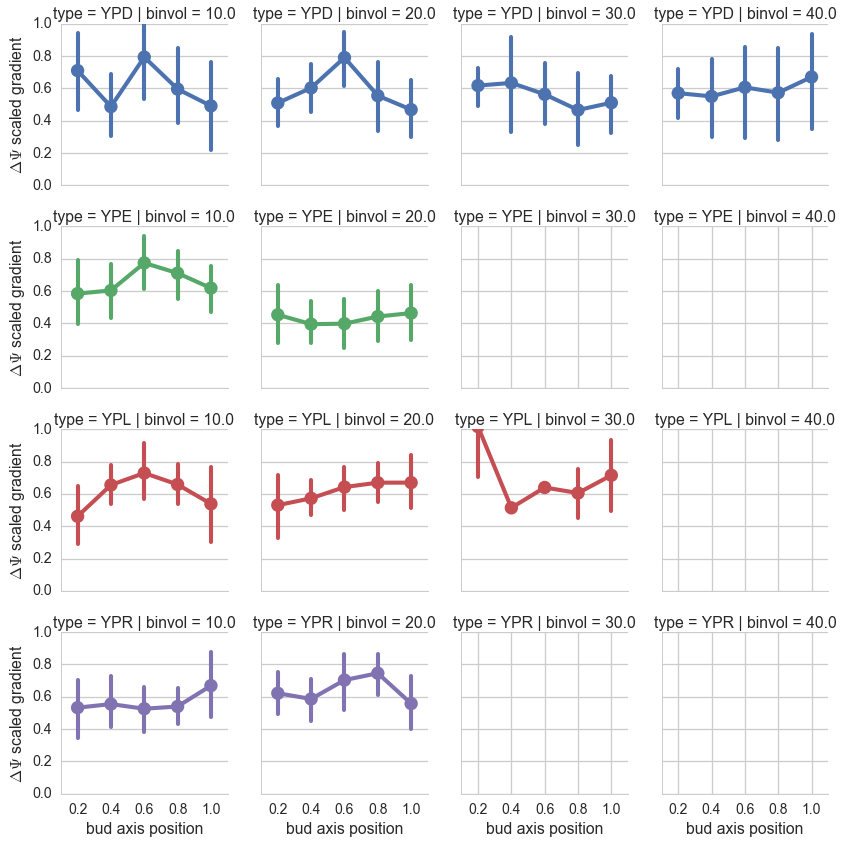

In [14]:
with sns.plotting_context('talk', font_scale=1.1):
    m = sns.FacetGrid(bigbinsbud,
                      row="type",
                      col="binvol",
                      hue='type',
                      col_order=binsvolbud[1:])
    m = m.map(sns.pointplot,
              'bud axis position',
              r'$\Delta\Psi$ scaled gradient')
    m.set_xticklabels(fontsize=14)
    m.set_xlabels("bud axis position")
    m.set(ylim=(0, 1.))